# Debug: Frame Decoding (.ravi & .mp4)
Interaktives Notebook zum Untersuchen des ersten (und weiterer) Frames einer Video-Datei.

## Ziele
- Roh-Frame Shape/Dtype inspizieren (besonders Fälle wie (1, N) bei MP4)
- Metadaten (w,h,n,fps) prüfen
- Rekonstruktion / Umwandlung wie im aktuellen Code testen
- Alternative Heuristiken ausprobieren, falls Darstellung noch falsch ist
- Unterschiede zwischen .ravi (uint16->invertiertes BGR) und .mp4 (direktes BGR) sichtbar machen

## Anleitung
1. Pfad zur Datei (.mp4 oder .ravi) in der nächsten Zelle setzen.
2. 'Meta & Raw Frame' Zelle ausführen.
3. Für MP4: Rekonstruktions-Vergleich und Visualisierung ausführen.
4. Optional mehrere Frames scannen um zu sehen, ob Flattening konsistent auftritt.
5. Anpassungen an den Rekonstruktionsfunktionen vornehmen und erneut testen.

In [45]:
# Parameter: Pfad zur Test-Datei setzen (absoluter oder relativer Pfad)
video_path = r'../BYS_XAISwallow/uploads/15-01-25_7_p.mp4'  # <- anpassen
# Falls .ravi testen: z.B. video_path = r'C:/pfad/zum/video.ravi'
max_scan_frames = 50  # wie viele Frames für Scan-Zelle
little_endian = True  # für .ravi Decoding

In [46]:
import os, cv2, numpy as np, math, time, json
from pathlib import Path
import matplotlib.pyplot as plt

# Import der bestehenden Utils aus dem Projekt-Pfad
import sys
root = Path('..').resolve()
if str(root) not in sys.path:
    sys.path.insert(0, str(root))
try:
    from BYS_XAISwallow.ravi_utils import decode_ravi_frame, u16_to_bgr8
except Exception as ex:
    print('Warnung: konnte ravi_utils nicht importieren:', ex)

In [47]:
def read_raw_first_frame(path: str):
    cap = cv2.VideoCapture(path)
    cap.set(cv2.CAP_PROP_FORMAT, -1)
    if not cap.isOpened():
        raise RuntimeError('Kann Video nicht öffnen: ' + path)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) or 0)
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) or 0)
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    fps = float(cap.get(cv2.CAP_PROP_FPS) or 0.0) or 32.0
    ok, raw = cap.read()
    cap.release()
    return ok, raw, (w,h,n,fps)

def reconstruct_mp4_frame(raw, w, h):
    # Implementierung analog aktuellem Code (vereinfacht)
    if raw is None:
        return None, 'raw=None'
    if raw.ndim == 2 and raw.shape[0] == 1 and w>0 and h>0:
        flat = raw.reshape(-1)
        expected3 = w*h*3
        expected1 = w*h
        if flat.size == expected3:
            return flat.reshape(h,w,3), 'flat->(h,w,3)'
        if flat.size == expected1:
            gray = flat.reshape(h,w)
            return cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR), 'flat->gray->BGR'
        if w>0 and flat.size % (w*3) == 0:
            hg = flat.size // (w*3)
            try:
                return flat.reshape(hg,w,3), f'flat heuristic hg={hg}'
            except Exception:
                pass
        return cv2.cvtColor(raw, cv2.COLOR_GRAY2BGR), 'fallback gray convert'
    # Normalcase
    if raw.ndim == 2 or (raw.ndim==3 and raw.shape[2]==1):
        return cv2.cvtColor(raw, cv2.COLOR_GRAY2BGR), 'gray->BGR'
    if raw.ndim==3 and raw.shape[2]==3:
        return raw, 'BGR passt'
    if raw.ndim==3 and raw.shape[2]==4:
        return cv2.cvtColor(raw, cv2.COLOR_BGRA2BGR), 'BGRA->BGR'
    return raw[:, :, :3].copy(), 'slice first 3 channels'

def decode_ravi(raw, w, h, little_endian=True):
    u16 = decode_ravi_frame(raw, w, h, little_endian=little_endian)
    return u16_to_bgr8(u16)

In [49]:
# Meta & Raw Frame
assert os.path.exists(video_path), f'Pfad existiert nicht: {video_path}'
ok, raw, meta = read_raw_first_frame(video_path)
w,h,n,fps = meta
print('OK:', ok, '| raw shape:', (None if raw is None else raw.shape), '| dtype:', (None if raw is None else raw.dtype))
print('Meta -> w:', w, 'h:', h, 'frames:', n, 'fps:', fps)
ext = os.path.splitext(video_path)[1].lower()
print('Extension:', ext)
first_frame = None
if ext == '.ravi':
    if ok and raw is not None:
        first_frame = decode_ravi(raw, w, h, little_endian=little_endian)
        print('RAVI decoded ->', first_frame.shape, first_frame.dtype)
else:
    if ok and raw is not None:
        first_frame, how = reconstruct_mp4_frame(raw, w, h)
        print('MP4 reconstruct:', how, '->', first_frame.shape, first_frame.dtype)
# Schnelle Statistik
if first_frame is not None:
    print('min/max:', first_frame.min(), first_frame.max())
else:
    print('Kein Frame decodiert.')

AssertionError: Pfad existiert nicht: ../BYS_XAISwallow/uploads/15-01-25_7_p.mp4

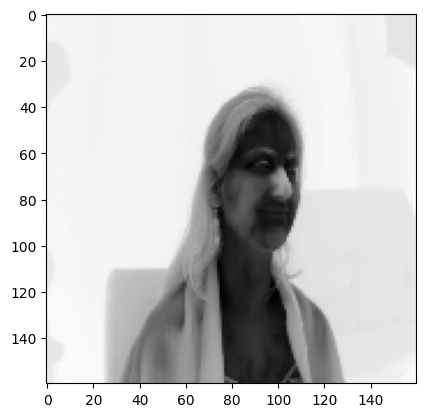

In [ ]:
import cv2
import matplotlib.pyplot as plt

video_path = r'../BYS_XAISwallow/uploads/15-01-25_7_p_video.mp4'  # <- anpassen
cap = cv2.VideoCapture(video_path)
ok, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = cv2.resize(frame, (w, h), interpolation=cv2.INTER_LINEAR)
cap.release()
plt.imshow(frame) 

In [ ]:
# Sicheres Rekonstruktions-Beispiel (verwendet vorhandene Hilfsfunktion reconstruct_mp4_frame)
# Ziel: keine ValueError wenn flaches raw nicht die erwartete Größe hat.

recon_frame = None
# berechne expected3 hier lokal, statt auf eine evtl. nicht sichtbare Variable zu vertrauen
expected3 = w * h * 3
if ext != '.ravi' and raw is not None:
    if isinstance(raw, np.ndarray) and getattr(raw, 'ndim', None) == 2 and raw.shape[0] == 1 and w > 0 and h > 0:
            flat = raw.reshape(-1)
            print('Flat size:', flat.size, 'expected3:', expected3, 'w*h:', w*h)
            if flat.size == expected3:
                recon_frame = flat.reshape(h, w, 3)
                print('Reshaped exact to (h,w,3).')
            elif flat.size > expected3:
                recon_frame = flat[:expected3].reshape(h, w, 3)
                print('Truncated flat to expected3 and reshaped to (h,w,3).')
            elif flat.size == w * h:
                gray = flat.reshape(h, w)
                recon_frame = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
                print('Interpreted flat as grayscale and converted to BGR.')
            else:
                # Fallback: benutze vorhandene Heuristik (reconstruct_mp4_frame)
                recon_frame, how = reconstruct_mp4_frame(raw, w, h)
                print('Fallback reconstruct_mp4_frame ->', how)
        else:
            recon_frame, how = reconstruct_mp4_frame(raw, w, h)
            print('Normal path ->', how)

        if recon_frame is not None:
            print('Reconstructed frame shape:', recon_frame.shape, 'dtype:', recon_frame.dtype)
        else:
            print('Rekonstruktion lieferte kein Frame.')
else:
	print('Nicht anwendbar für .ravi oder raw ist None.')

Flat size: 9148 expected3: 921600 w*h: 307200
Fallback reconstruct_mp4_frame -> fallback gray convert
Reconstructed frame shape: (1, 9148, 3) dtype: uint8


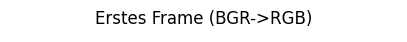

In [6]:
# Visualisierung des ersten Frames (rekonstruiert)
if 'first_frame' in globals() and first_frame is not None:
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
    plt.title('Erstes Frame (BGR->RGB)')
    plt.axis('off')
else:
    print('Kein Frame zum Anzeigen.')

In [7]:
# Vergleich: naive Annahme vs Rekonstruktion (nur sinnvoll bei flachem MP4 Rohframe)
if ok and raw is not None and ext != '.ravi' and raw.ndim == 2 and raw.shape[0] == 1:
    flat = raw.reshape(-1)
    expected3 = w*h*3
    naive = flat.copy()
    if flat.size >= expected3 and w>0 and h>0:
        try:
            reshaped = flat[:expected3].reshape(h,w,3)
            plt.figure(figsize=(10,5))
            plt.subplot(1,2,1); plt.imshow(naive[:min(naive.size,500)].reshape(1,-1), cmap='gray'); plt.title('Naive Flat (Ausschnitt)'); plt.axis('off')
            plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(reshaped, cv2.COLOR_BGR2RGB)); plt.title('Reshape (h,w,3)')
            plt.tight_layout(); plt.show()
        except Exception as ex:
            print('Reshape Fehler:', ex)
    else:
        print('Größen stimmen nicht für direktes (h,w,3) reshape.')
else:
    print('Kein flaches MP4 Frame für diesen Vergleich oder .ravi Datei.')

Größen stimmen nicht für direktes (h,w,3) reshape.


In [ ]:
# Scan mehrerer Frames: wie oft flach / normal?
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_FORMAT, -1)
flat_cnt = 0
normal_cnt = 0
frames_checked = 0
while frames_checked < max_scan_frames:
    ok2, fr = cap.read()
    if not ok2 or fr is None:
        break
    if fr.ndim == 2 and fr.shape[0] == 1:
        flat_cnt += 1
    else:
        normal_cnt += 1
    frames_checked += 1
cap.release()
print(f'Frames gecheckt: {frames_checked} | flach: {flat_cnt} | normal: {normal_cnt}')
if flat_cnt > 0 and normal_cnt > 0:
    print('Mischformen gefunden -> evtl. instabiler Decoder / Timing.')
elif flat_cnt > 0:
    print('Alle/Mehrheit flach -> heuristische Rekonstruktion notwendig.')
else:
    print('Alle/Mehrheit normal.')

## Eigene Heuristik / Experimente
Passe den folgenden Code an, um alternative Rekonstruktionen zu testen und das Ergebnis unmittelbar zu sehen.

In [ ]:
# Beispiel: alternative Heuristik ausprobieren
def alternative_reconstruct(raw, w, h):
    if raw.ndim == 2 and raw.shape[0] == 1 and w>0 and h>0:
        flat = raw.reshape(-1)
        expected3 = w*h*3
        if flat.size >= expected3:
            return flat[:expected3].reshape(h,w,3)
    return reconstruct_mp4_frame(raw, w, h)[0]

if ext != '.ravi' and ok and raw is not None:
    alt = alternative_reconstruct(raw, w, h)
    if alt is not None:
        plt.figure(figsize=(5,5)); plt.imshow(cv2.cvtColor(alt, cv2.COLOR_BGR2RGB)); plt.title('Alternative Rekonstruktion'); plt.axis('off')
    else:
        print('Alternative Rekonstruktion fehlgeschlagen.')
else:
    print('Nicht anwendbar für .ravi oder kein Frame.')